We invest in customers (acquisition costs, offline ads, promotions, discounts & etc.) to generate revenue and be profitable. Naturally, these actions make some customers super valuable in terms of **lifetime value** but there are always some customers who pull down the profitability. We need to identify these behavior patterns, segment customers and act accordingly.  

There are several approaches:  
* Historical CLV = $\sum$ revenues of all past transaction * profit. (it does not count for tenure, retention and churn).   
* Basic CLV = Avg Revenue * Profit Margin * Avg Lifspan   
* Granular CLV = (avg revenue per transaction * Avg Freq * Profit Margin ) * Avg Lifespan
* Traditional CLV = (Avg Revenue Profit Margin)* $\frac{Retention Rate}{Churn Rate}$

Where retention = $\frac{Monthly active user}{user size}$    
churn = 1 - retention


In [2]:
from __future__ import division
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline

from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans



In [4]:
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [7]:
tx_data = pd.read_csv('./Downloads/data/OnlineRetail.csv', encoding= 'unicode_escape')
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [8]:
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])
tx_data['InvoiceDate'].describe()

count                  541909
unique                  23260
top       2011-10-31 14:41:00
freq                     1114
first     2010-12-01 08:26:00
last      2011-12-09 12:50:00
Name: InvoiceDate, dtype: object

In [9]:
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)

In [11]:
date(2007, 12, 5)

datetime.date(2007, 12, 5)

In [10]:
tx_3m = tx_uk[(tx_uk.InvoiceDate < date(2011,6,1)) & (tx_uk.InvoiceDate >= date(2011,3,1))].reset_index(drop=True)
tx_6m = tx_uk[(tx_uk.InvoiceDate >= date(2011,6,1)) & (tx_uk.InvoiceDate < date(2011,12,1))].reset_index(drop=True)

TypeError: Invalid comparison between dtype=datetime64[ns] and date

In [13]:
tx_3m['InvoiceDate'].describe()

count                   95193
unique                   4852
top       2011-04-18 13:13:00
freq                      333
first     2011-03-01 08:30:00
last      2011-05-31 15:53:00
Name: InvoiceDate, dtype: object

In [14]:
tx_user = pd.DataFrame(tx_3m['CustomerID'].unique())
tx_user.columns = ['CustomerID']

# Recency

In [15]:
tx_max_purchase = tx_3m.groupby('CustomerID').InvoiceDate.max().reset_index()

In [16]:
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [17]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [18]:
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')

In [19]:
tx_user.head()

,CustomerID,Recency
0,14620.0,12
1,14740.0,4
2,13880.0,25
3,16462.0,91
4,17068.0,11


In [20]:
tx_user.Recency.describe()

count    1840.000000
mean       35.145652
std        26.231112
min         0.000000
25%        12.000000
50%        26.000000
75%        56.000000
max        91.000000
Name: Recency, dtype: float64

In [21]:
plot_data = [
    go.Histogram(
        x=tx_user['Recency']
    )
]

plot_layout = go.Layout(
        title='Recency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

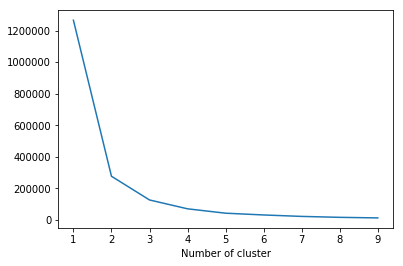

In [22]:
sse={}
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [23]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Recency']])
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [24]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,444.0,24.373874,4.959870,17.0,20.0,23.0,27.0,35.0
1,349.0,76.885387,8.373023,64.0,70.0,76.0,84.0,91.0
2,439.0,50.020501,7.377743,39.0,43.0,49.0,56.0,63.0
3,608.0,8.312500,4.404323,0.0,5.0,8.0,12.0,16.0


In [25]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final


In [26]:
tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

# Frequency

In [27]:
tx_frequency = tx_3m.groupby('CustomerID').InvoiceDate.count().reset_index()

In [28]:
tx_frequency.columns = ['CustomerID','Frequency']

In [29]:
tx_frequency.head()

,CustomerID,Frequency
0,12747.0,35
1,12748.0,582
2,12749.0,54
3,12821.0,6
4,12823.0,1


In [30]:
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

In [31]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,14620.0,12,3,30
1,14740.0,4,3,89
2,17068.0,11,3,76
3,12971.0,4,3,73
4,15194.0,6,3,64


In [32]:
tx_user.Frequency.describe()

count    1840.000000
mean       38.958152
std        60.968929
min         1.000000
25%        12.000000
50%        23.000000
75%        47.000000
max      1364.000000
Name: Frequency, dtype: float64

In [33]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
        title='Frequency'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



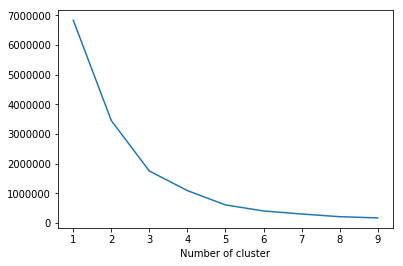

In [34]:
sse={}
tx_frequency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_frequency)
    tx_frequency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [35]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Frequency']])
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])

In [36]:
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1600.0,24.075000,17.603886,1.0,10.0,20.0,35.00,69.0
1,11.0,496.000000,125.912668,331.0,422.5,452.0,570.00,730.0
2,228.0,115.539474,43.867273,70.0,82.0,103.5,130.25,285.0
3,1.0,1364.000000,NaN,1364.0,1364.0,1364.0,1364.00,1364.0


In [37]:
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

# Monetary Value

In [38]:
tx_3m['Revenue'] = tx_3m['UnitPrice'] * tx_3m['Quantity']

In [39]:
tx_revenue = tx_3m.groupby('CustomerID').Revenue.sum().reset_index()

In [40]:
tx_revenue.head()

,CustomerID,Revenue
0,12747.0,1082.09
1,12748.0,4336.73
2,12749.0,782.10
3,12821.0,92.72
4,12823.0,459.00


In [41]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

In [42]:
tx_user.Revenue.describe()

count     1840.000000
mean       738.715017
std       1640.430156
min      -1462.500000
25%        210.237500
50%        369.825000
75%        749.490000
max      35085.480000
Name: Revenue, dtype: float64

In [43]:
plot_data = [
    go.Histogram(
        x=tx_user.query('Revenue < 10000')['Revenue']
    )
]

plot_layout = go.Layout(
        title='Monetary Value'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [44]:
import warnings
warnings.filterwarnings("ignore")

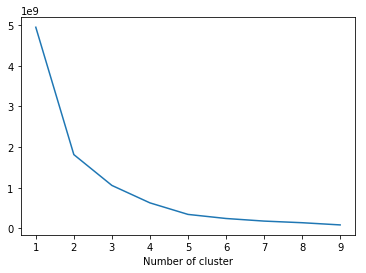

In [45]:
sse={}
tx_revenue = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_revenue)
    tx_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [46]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])
tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])

In [47]:
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

In [48]:
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1756.0,504.760245,444.567580,-1462.50,204.3075,349.590,666.8325,2131.72
1,72.0,3760.423486,1538.877714,2159.16,2685.1875,3141.610,4222.5050,7969.99
2,10.0,14092.686000,2855.109881,10348.13,11268.3675,15124.345,16124.8250,17700.64
3,2.0,30599.645000,6343.928696,26113.81,28356.7275,30599.645,32842.5625,35085.48


# Overall Segmentation

In [49]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,14620.0,12,3,30,0,393.28,0
1,15194.0,6,3,64,0,1439.02,0
2,18044.0,5,3,57,0,808.96,0
3,18075.0,12,3,35,0,638.12,0
4,15241.0,0,3,64,0,947.55,0


In [50]:
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

In [51]:
tx_user.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,77.023952,18.278443,295.913533
1,50.947494,24.522673,366.699332
2,26.642857,31.028571,500.863667
3,10.295316,36.584521,631.428473
4,8.076923,103.315385,1972.010777
5,6.482759,138.965517,4326.155172
6,7.357143,322.071429,12177.627143
7,3.000000,779.333333,11350.896667


In [52]:
tx_user.groupby('OverallScore')['Recency'].count()

OverallScore
0    334
1    419
2    420
3    491
4    130
5     29
6     14
7      3
Name: Recency, dtype: int64

In [53]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value' 

In [54]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [55]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [56]:
tx_graph = tx_user.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# LTV

In [57]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value


In [58]:
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom


In [59]:
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']

In [60]:
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID','m6_Revenue']

In [61]:
tx_6m.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
0,555156,23299,FOOD COVER WITH BEADS SET 2,6,2011-06-01 07:37:00,3.75,15643.0,United Kingdom,22.50
1,555156,22847,BREAD BIN DINER STYLE IVORY,1,2011-06-01 07:37:00,16.95,15643.0,United Kingdom,16.95
2,555157,23075,PARLOUR CERAMIC WALL HOOK,16,2011-06-01 07:38:00,4.15,15643.0,United Kingdom,66.40
3,555157,47590B,PINK HAPPY BIRTHDAY BUNTING,6,2011-06-01 07:38:00,5.45,15643.0,United Kingdom,32.70
4,555157,22423,REGENCY CAKESTAND 3 TIER,4,2011-06-01 07:38:00,12.75,15643.0,United Kingdom,51.00


In [62]:
plot_data = [
    go.Histogram(
        x=tx_user_6m.query('m6_Revenue < 10000')['m6_Revenue']
    )
]

plot_layout = go.Layout(
        title='6m Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [63]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='CustomerID', how='left')

In [64]:
tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,NaN
1,15194.0,6,3,64,0,1439.02,0,3,Mid-Value,3232.20
2,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54
3,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75
4,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04


In [65]:
tx_merge = tx_merge.fillna(0)

In [66]:
tx_merge.groupby('Segment')['m6_Revenue'].mean()

Segment
High-Value    17968.362609
Low-Value       703.037741
Mid-Value      1717.565155
Name: m6_Revenue, dtype: float64

In [67]:
tx_graph = tx_merge.query("m6_Revenue < 30000")

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [68]:
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]

In [69]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(tx_merge[['m6_Revenue']])
tx_merge['LTVCluster'] = kmeans.predict(tx_merge[['m6_Revenue']])

In [70]:
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

In [71]:
tx_merge.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1394.0,396.137189,419.891843,-609.40,0.000,294.220,682.4300,1429.87
1,371.0,2492.794933,937.341566,1445.31,1731.980,2162.930,3041.9550,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.435,6986.545,9607.3225,16756.31


In [72]:
tx_cluster = tx_merge.copy()

In [73]:
tx_cluster.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00,0
1,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54,0
2,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75,0
3,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04,0
4,15660.0,4,3,34,0,484.62,0,3,Mid-Value,858.09,0


In [74]:
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,1394.0,396.137189,419.891843,-609.40,0.000,294.220,682.4300,1429.87
1,371.0,2492.794933,937.341566,1445.31,1731.980,2162.930,3041.9550,5287.39
2,56.0,8222.565893,2983.572030,5396.44,6151.435,6986.545,9607.3225,16756.31


In [75]:
tx_cluster.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,14620.0,12,3,30,0,393.28,0,3,Mid-Value,0.00,0
1,18044.0,5,3,57,0,808.96,0,3,Mid-Value,991.54,0
2,18075.0,12,3,35,0,638.12,0,3,Mid-Value,1322.75,0
3,15241.0,0,3,64,0,947.55,0,3,Mid-Value,791.04,0
4,15660.0,4,3,34,0,484.62,0,3,Mid-Value,858.09,0


In [76]:
tx_class = pd.get_dummies(tx_cluster)

In [77]:
tx_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,14620.0,12,3,30,0,393.28,0,3,0.00,0,0,0,1
1,18044.0,5,3,57,0,808.96,0,3,991.54,0,0,0,1
2,18075.0,12,3,35,0,638.12,0,3,1322.75,0,0,0,1
3,15241.0,0,3,64,0,947.55,0,3,791.04,0,0,0,1
4,15660.0,4,3,34,0,484.62,0,3,858.09,0,0,0,1


In [78]:
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
m6_Revenue            0.845933
Revenue               0.600491
RevenueCluster        0.467191
OverallScore          0.372579
FrequencyCluster      0.362247
Frequency             0.359601
Segment_High-Value    0.352387
RecencyCluster        0.236899
Segment_Mid-Value     0.167797
CustomerID           -0.028401
Recency              -0.237249
Segment_Low-Value    -0.265315
Name: LTVCluster, dtype: float64

In [79]:
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

In [81]:
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,objective= 'multi:softprob',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))



Accuracy of XGB classifier on training set: 0.91
Accuracy of XGB classifier on test set: 0.84


In [82]:
tx_class.groupby('LTVCluster').CustomerID.count()/tx_class.CustomerID.count()

LTVCluster
0    0.765513
1    0.203734
2    0.030752
Name: CustomerID, dtype: float64

In [83]:
y_pred = ltv_xgb_model.predict(X_test)

In [84]:
print classification_report(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        70
           1       0.62      0.56      0.59        18
           2       0.50      0.50      0.50         4

   micro avg       0.84      0.84      0.84        92
   macro avg       0.68      0.66      0.67        92
weighted avg       0.83      0.84      0.83        92

